# **Analisis Sentimen Kebijakan Mobil Listrik**

- Nama    : Kurniawan Chandra Wijaya
- Universitas Gadjah Mada

## **1. Pemahaman Data**
---

**Import module:**

In [1]:
!git clone https://github.com/dotawan09/arkav.git

fatal: destination path 'arkav' already exists and is not an empty directory.


In [2]:
import os
import requests

# Visualisasi Data dan Manipulasi Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import tensorflow as tf
import seaborn as sns
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Data Preprocessing
import re
import string
import nltk
import langdetect
import ast
import collections
import itertools

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# for named entity recognition (NER)
from nltk import ne_chunk

from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords  #stopwords
from nltk.corpus import wordnet
from string import punctuation

from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

import gensim
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from PIL import Image

import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dalam beberapa tahun terakhir, pemerintah telah mengeluarkan berbagai kebijakan untuk mendorong penggunaan kendaraan listrik sebagai salah satu upaya mengurangi emisi karbon dan meningkatkan keberlanjutan lingkungan. Kebijakan ini menimbulkan berbagai reaksi dari masyarakat, yang diekspresikan melalui media sosial, termasuk Twitter. Dataset yang digunakan berisi tweet hasil scraping dari Twitter yang menyebutkan kata kunci seperti "mobil listrik," "motor listrik, "kebijakan mobil listrik," dan istilah terkait lainnya.


**Input dataset:**

In [3]:
df = pd.read_excel('Data Mining.xlsx')
display(df)

username                                          tweet_url  Label  \
0          RIlahi2   https://x.com/RIlahi2/status/1753363971141468216     -1   
1     dian97605702  https://x.com/dian97605702/status/178658916159...     -1   
2         kumparan  https://x.com/kumparan/status/1792359877412839526      0   
3        kompascom  https://x.com/kompascom/status/177641541559984...      1   
4     5teV3n_Pe9eL  https://x.com/5teV3n_Pe9eL/status/179597284180...     -1   
..             ...                                                ...    ...   
495       XueYaman  https://x.com/XueYaman/status/1752185167282937875      0   
496       hari_bdl  https://x.com/hari_bdl/status/1789273719782932881      0   
497     kompasiana  https://x.com/kompasiana/status/17505184347551...     -1   
498  CMTGforwarder  https://x.com/CMTGforwarder/status/17877552621...      0   
499       detikcom  https://x.com/detikcom/status/1765598751253565828      0   

                                             full_text  
0    Misalnya...subsidi motor atau mobil listrik di...  
1    @AzzamIzzulhaq ku tahu itu indonesia pernah pu...  
2    Berita populer kumparanOTO Minggu (19/5) estim...  
3    Ketika kesehatan baterai mobil listrik turun d...  
4    @kumparan Yo jelas mikir2 lah konsumen namanya...  
..                                                 ...  
495  @detikcom @gibran_tweet ternyata memang benar ...  
496  @NOTASLIMBOY Banting harga apa berarti sebelum...  
497  Dampak Mobil Listrik terhadap Usaha Tradisiona...  
498  @AzzamIzzulhaq @ganarmdhn Mobil listrik anak b...  
499  Wuling Bingo terbaru meluncur di China dengan ...  

[500 rows x 4 columns]

Dataset terdiri dari 500 tweet dan perlu diperhatikan bahwa telah dilakukan pelabelan manual dengan kode berikut.
- -1 untuk tweet dengan sentimen negatif,
- 0 untuk tweet dengan sentimen netral,
- 1 untuk tweet dengan sentimen positif, dan
- 10 untuk tweet yang tidak memiliki hubungan dengan konteks.
Selain itu, terdapat 5 tweet yang dinyatakan dengan bahasa daerah. Dari kelima tweet tersebut yang memiliki sentimen negatif, netral, atau positif--tidak keluar konteks telah diterjemahkan secara manual ke dalam bahasa Indonesia. Dasar dari penerjemahan manual ke dalam bahasa Indonesia karena jumlahnya yang sedikit.

### **1.1. Eksplorasi Data: Pengecekan Nilai *Missing* dan Duplikat**

In [4]:
df.isna().sum()

username     0
tweet_url    0
Label        0
full_text    0
dtype: int64

Terlihat bahwa tidak terdapat *missing values* pada data.

In [5]:
df.duplicated().sum()

0

Terlihat pula tidak terdapat data duplikasi.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   username   500 non-null    object
 1   tweet_url  500 non-null    object
 2   Label      500 non-null    int64 
 3   full_text  500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


### **1.2. Eksplorasi Data: Visualisasi**

#### **1.2.1. Sebaran Sentimen Label**

Visualisasi pertama yang akan dilakukan adalah melihat sebaran label aentimen.

In [7]:
df['Label'].value_counts()

Label
 0     162
-1     137
 10    116
 1      85
Name: count, dtype: int64

Untuk mempermudah visualisasi, pengkodean label akan dikembalikan ke dalam bentuk ["Netral", "Negative", "Positive", dan "Unrelated"].

In [8]:
df['Label'] = df['Label'].replace(0, 'Netral')
df['Label'] = df['Label'].replace(-1, 'Negative')
df['Label'] = df['Label'].replace(1, 'Positive')
df['Label'] = df['Label'].replace(10, 'Unrelated')

c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


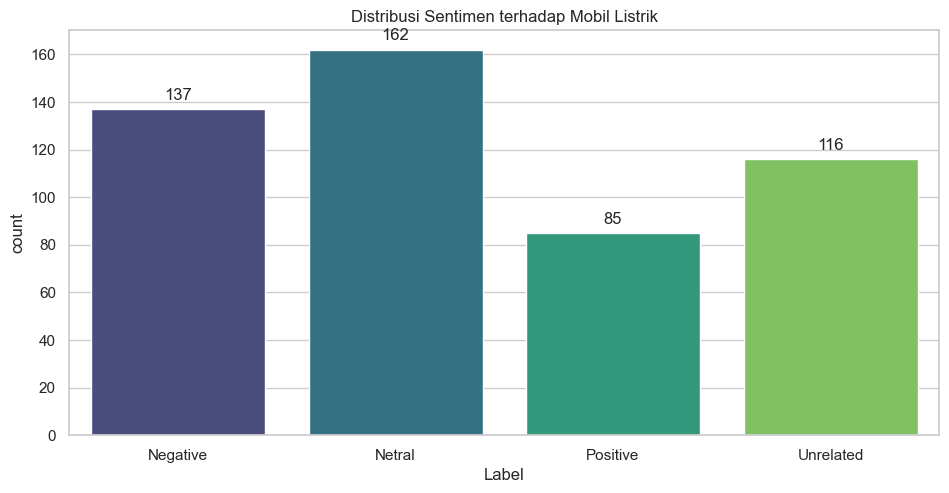

In [9]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Label', data=df, palette='viridis')
plt.title('Distribusi Sentimen terhadap Mobil Listrik')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Berdasarkan visualsiasi tersebut, terlihat bahwa mayoritas tweet bersikap netral terhadap kebijakan mobil listrik, khususnya di Indonesia. Disusul dengan tweet negatif, tidak berkorelasi, dan positif secara berurutan.

Terlihat bahwa tweet yang tidak memiliki hubungan dengan kebijakan mobil listrik cukup banyak, mencapai 116 tweet.

#### **1.2.2. Word Cloud Awal pada Tweet**

Sebagai gambaran awal terkait data, akan dibuat *word cloud* awal pada data tanpa prapemrosesan.

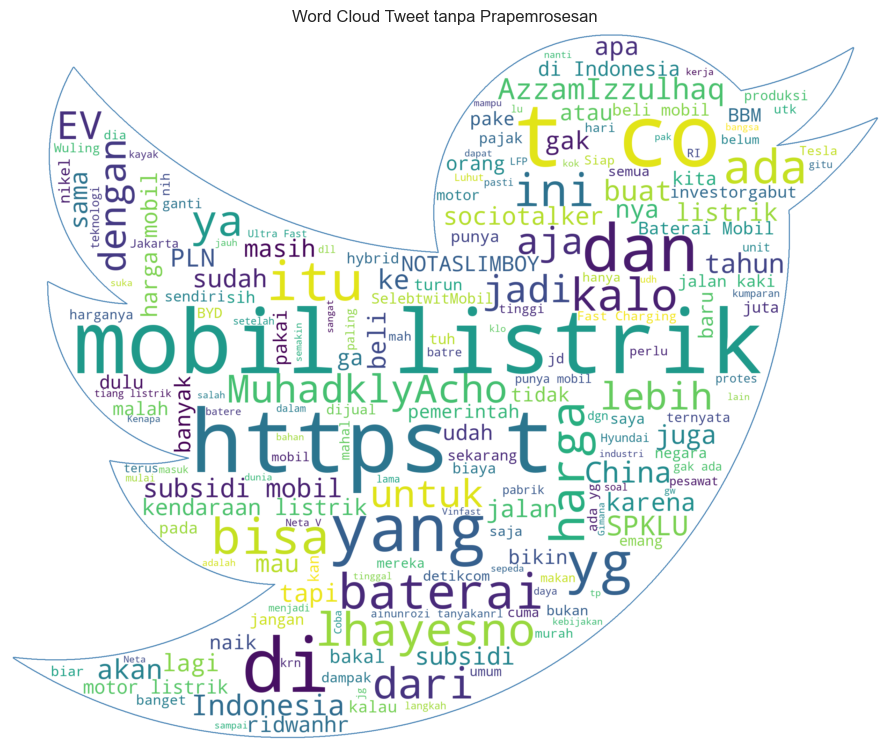

In [10]:
twitter_logo = Image.open('LogoTwitter.png')
mask = np.array(twitter_logo)
mask[mask[:, :, -1] == 0] = 255
mask = mask[:, :, :3]

text = ' '.join(df['full_text'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=800, background_color='white', mask=mask,
                      contour_width=3, contour_color='steelblue').generate(text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud Tweet tanpa Prapemrosesan")
plt.show()

Terlihat bahwa frasa mobil listrik teridentifikasi paling sering muncul.

## **2. Preprocessing Data**
---

Preprocessing data merupakan tahapan yang penting untuk dilakukan guna memastikan data yang didapatkan siap dianalisis lebih lanjut. Apabila merujuk pada visualisasi wordcloud sebelumnya, terlihat bahwa visualisasi belum representatif karena banyak kata yang tidak diperlukan tetap digunakan.

### **2.1. Penghapusan Data yang Tidak Berhubungan**

Data-data yang tidak berhubungan atau *unrelated* akan dihapuskan.

In [11]:
df = df[df['Label'] != 'Unrelated']

In [12]:
df['Label'] = df['Label'].replace('Netral', 1)
df['Label'] = df['Label'].replace('Negative', 2)
df['Label'] = df['Label'].replace('Positive', 0)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_25708\3570144586.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace('Positive', 0)


In [13]:
df.shape

(384, 4)

### **2.2. Penghapusan Simbol-Simbol dan Karakter yang Tidak Penting**

In [14]:
def clean_text(text):
    # Menghapus username
    text = re.sub(r'@\w+', '', text)

    # Menghapus tag
    text = re.sub(r'#\w+', '', text)

    # Hapus teks dalam []
    text = re.sub(r'\[\w+]', '', text)

    # Penghapusan Karakter Non-Alfanumerik
    text = re.sub(r'[^\w\s]', '', text)

    # Menghapus URL
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\b\w+(?:com|org)\b', '', text)

    # Case Folding: Menyeragamkan teks (lower case)
    text = text.lower()

    # Menghapus whitespace (spasi ganda, tab, newline)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    #  Punctuation Removal: Menghapus tanda baca (seperti titik, koma, tanda seru, tanda tanya, dan titik koma)
    text = text.translate(str.maketrans('', '', string.punctuation))

    PUNCT_TO_REMOVE = '"#$%^*()_+-=<>;[]|{}~:â€™¦£?ðÿ¼'
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

    return text

Diterapkan pada dataset:

In [15]:
df['full_text'] = df['full_text'].apply(clean_text)

In [16]:
display(df)

username                                          tweet_url  Label  \
0          RIlahi2   https://x.com/RIlahi2/status/1753363971141468216      2   
1     dian97605702  https://x.com/dian97605702/status/178658916159...      2   
2         kumparan  https://x.com/kumparan/status/1792359877412839526      1   
3        kompascom  https://x.com/kompascom/status/177641541559984...      0   
4     5teV3n_Pe9eL  https://x.com/5teV3n_Pe9eL/status/179597284180...      2   
..             ...                                                ...    ...   
495       XueYaman  https://x.com/XueYaman/status/1752185167282937875      1   
496       hari_bdl  https://x.com/hari_bdl/status/1789273719782932881      1   
497     kompasiana  https://x.com/kompasiana/status/17505184347551...      2   
498  CMTGforwarder  https://x.com/CMTGforwarder/status/17877552621...      1   
499       detikcom  https://x.com/detikcom/status/1765598751253565828      1   

                                             full_text  
0    misalnyasubsidi motor atau mobil listrik diali...  
1    ku tahu itu indonesia pernah punya industri pe...  
2    berita populer kumparanoto minggu 195 estimasi...  
3    ketika kesehatan baterai mobil listrik turun d...  
4    yo jelas mikir2 lah konsumen namanya bekas bat...  
..                                                 ...  
495  ternyata memang benar nikel itu bakal jadi bah...  
496  banting harga apa berarti sebelumnya ambil unt...  
497  dampak mobil listrik terhadap usaha tradisiona...  
498  mobil listrik anak bangsa dijegal karena gagal...  
499  wuling bingo terbaru meluncur di china dengan ...  

[384 rows x 4 columns]

### **2.3. Pembenahan pada *Slang Words***

Kamis di bawah ini akan digunakan untuk mengganti *slang words* menjadi kata baku.

In [17]:
# kamus 1
sl1 = {"@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "uu" : "undang undang", "kementrian" : "kementerian", "trus" : "terus", "truss" : "terus", "trusss" : "terus", "ttapi": "tapi", "piluhan": "pilihan", "geratis" : "gratis", 'bany': 'banyak', 'bat' : 'banget', 'th':'tahun', 'indo':'indonesia', 'indon':'indonesia','indons':'indonesia', 'indone':'indonesia', 'indones':'indonesia', 'jngka': 'jangka', 'tqpi' : 'tapi', 'haha':'tertawa', 'hahaha':'tertawa', 'mikir2':'mikir-mikir', 'dibangga2in': 'dibangga-banggakan', 'misalnyasubsidi': 'misalnya subsidi', 'yy':'ya', 'itung2an':'hitung-hitungan', 'lagi²':'lagi-lagi', 'bgitulah':'begitulah', 'mirip2':'mirip-mirip', 'molis':'mobil listrik', 'moblis':'mobil listrik', 'ev':'mobil listrik', 'beterai':'baterai', 'udh':'udah', 'over':'lebih', 'ngk':'tidak', 'ogah':'tidak mau', 'byk':'banyak', 'kendara':'kendaraan', 'ngab':'bang', 'batere':'baterai'}

In [18]:
# kamus 2
sl2 = pd.read_csv("https://raw.githubusercontent.com/haryoa/indo-collex/main/dict/inforformal-formal-Indonesian-dictionary.tsv", sep="\t")
sl2.set_index("informal", drop=True, inplace=True)
sl2 = sl2.to_dict()["formal"]
sl2

# kamus 3
sl3 = pd.read_csv("https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt", sep="\t", header=None)
sl3.set_index(0, drop=True, inplace=True)
sl3 = sl3.to_dict()[1]

# Gabungkan semua kamus slang words
sl_word = {**sl1, **sl2, **sl3}

# Kamus 4
file = open("arkav/combined_slang_words.txt")
content = file.read()
dicti = ast.literal_eval(content)
slang = pd.DataFrame(dicti.items(),columns=['original','replacement'])
slang_dict_map = dict(zip(slang['original'], slang['replacement']))


print(dict(list(sl_word.items())[1:10]))

{'abis': 'habis', 'ad': 'ada', 'adlh': 'adalah', 'afaik': 'as far as i know', 'ahaha': 'haha', 'aj': 'saja', 'ajep-ajep': 'dunia gemerlap', 'ak': 'saya', 'akika': 'aku'}


In [19]:
def slang_preprocess(text, slang_words = sl_word, slang_dict_map = slang_dict_map):
    # SlangWords Handling
    text = ' '.join([slang_words.get(word, word) for word in text.split()])
    text = ' '.join([slang_dict_map[word] if word in slang_dict_map else word for word in text.split(' ')])

    return text

Menerapkan pada dataset:

In [20]:
# Terapkan pada dataset
df['full_text'] = df['full_text'].apply(slang_preprocess)

In [21]:
display(df)

username                                          tweet_url  Label  \
0          RIlahi2   https://x.com/RIlahi2/status/1753363971141468216      2   
1     dian97605702  https://x.com/dian97605702/status/178658916159...      2   
2         kumparan  https://x.com/kumparan/status/1792359877412839526      1   
3        kompascom  https://x.com/kompascom/status/177641541559984...      0   
4     5teV3n_Pe9eL  https://x.com/5teV3n_Pe9eL/status/179597284180...      2   
..             ...                                                ...    ...   
495       XueYaman  https://x.com/XueYaman/status/1752185167282937875      1   
496       hari_bdl  https://x.com/hari_bdl/status/1789273719782932881      1   
497     kompasiana  https://x.com/kompasiana/status/17505184347551...      2   
498  CMTGforwarder  https://x.com/CMTGforwarder/status/17877552621...      1   
499       detikcom  https://x.com/detikcom/status/1765598751253565828      1   

                                             full_text  
0    misalnya subsidi motor atau mobil listrik dial...  
1    ku tahu itu indonesia pernah punya industri pe...  
2    berita populer kumparanoto minggu 195 estimasi...  
3    ketika kesehatan baterai mobil listrik turun d...  
4    iya jelas mikir-mikir lah konsumen namanya bek...  
..                                                 ...  
495  ternyata memang benar nikel itu bakal jadi bah...  
496  banting harga apa berarti sebelumnya ambil unt...  
497  dampak mobil listrik terhadap usaha tradisiona...  
498  mobil listrik anak bangsa dijegal karena gagal...  
499  wuling bingo terbaru meluncur di china dengan ...  

[384 rows x 4 columns]

### **2.4. *Stop Words***

Menghapus *stop words* atau kata-kata yang kurang penting, seperti imbuhan atau konjungsi.

In [22]:
# kamus 1: sastrawi
factory = StopWordRemoverFactory()
sw_id1 = factory.get_stop_words()

# kamus 2
sw_id2 = pd.read_csv("https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt",header=None)
sw_id2 = list(sw_id1[0])

# kamus 3
sw_id3 = ['kalau', 'terus', 'ini', 'ada', 'iya', 'ke', 'di', 'dari', 'kalo', 'kalau', 'terus', 'trs', 'ini', 'ada', 'iya', 'iya', 'gitu', 'kayak',
    'ga', 'gak', 'nggak', 'ngga', 'sih', 'aja', 'deh', 'kan', 'lah', 'dong', 'nya',
    'kok', 'sama', 'dan', 'atau', 'yang', 'untuk', 'buat', 'ke', 'di', 'dari', 'seperti',
    'bgt', 'banget', 'gimana', 'begitu', 'kenapa', 'mengapa', 'mau', 'aku', 'saya',
    'gue', 'gua', 'lo', 'lu', 'kamu', 'dia', 'mereka', 'kita', 'kalian', 'lagi',
    'udah', 'sudah', 'belum', 'baru', 'tadi', 'tuh', 'nih', 'ya', 'iy', 'ok', 'oke',
    'oke', 'okey', 'mks', 'makasih', 'thanks', 'terima kasih',
    'jd', 'jadi', 'sama', 'btw', 'bytheway', 'kayak', 'spt', 'sperti', 'dgn', 'dengan',
    'aja', 'aja', 'nah', 'yuk', 'yok', 'nih', 'kek', 'yg', 'malah', 'siapa', 'bagaimana',
    'krn', 'karena', 'sy', 'gw', 'tapi', 'tp', 'cm', 'cuman', 'juga', 'jg', 'buat', 'krn',
    'hallo', 'halo', 'woi', 'yoi', 'bro', 'sis', 'gan', 'agan', 'sob', 'coy', 'cuy',
    'boss', 'bos', 'brow', 'sis', 'kak', 'kaka', 'om', 'tante', 'pak', 'bu', 'bapak', 'ibu', 'misal', 'apa', 'bang', 'sok'
]

# Tambahkan kamus lainnya
sw_id4 = stopwords.words("indonesian") + list(punctuation)


# Gabungkan
sw_id = sw_id1 + sw_id2 + sw_id3

sw_id[:20]

['yang',
 'untuk',
 'pada',
 'ke',
 'para',
 'namun',
 'menurut',
 'antara',
 'dia',
 'dua',
 'ia',
 'seperti',
 'jika',
 'jika',
 'sehingga',
 'kembali',
 'dan',
 'tidak',
 'ini',
 'karena']

In [23]:
def stopwords_removal(words,stopword = sw_id):
    return [word for word in words if word not in stopword]
def stop_word_preprocessing(text, sw = sw_id):
   # Stop Words Removal
    text = text.split()
    text = " ".join(stopwords_removal(text, sw))

    return text

Membuat kolom baru:

In [24]:
df['stop_word'] = df['full_text'].apply(stop_word_preprocessing)

In [25]:
df.head()

username                                          tweet_url  Label  \
0       RIlahi2   https://x.com/RIlahi2/status/1753363971141468216      2   
1  dian97605702  https://x.com/dian97605702/status/178658916159...      2   
2      kumparan  https://x.com/kumparan/status/1792359877412839526      1   
3     kompascom  https://x.com/kompascom/status/177641541559984...      0   
4  5teV3n_Pe9eL  https://x.com/5teV3n_Pe9eL/status/179597284180...      2   

                                           full_text  \
0  misalnya subsidi motor atau mobil listrik dial...   
1  ku tahu itu indonesia pernah punya industri pe...   
2  berita populer kumparanoto minggu 195 estimasi...   
3  ketika kesehatan baterai mobil listrik turun d...   
4  iya jelas mikir-mikir lah konsumen namanya bek...   

                                           stop_word  
0  misalnya subsidi motor mobil listrik dialihkan...  
1  ku tahu indonesia pernah punya industri pesawa...  
2  berita populer kumparanoto minggu 195 estimasi...  
3  kesehatan baterai mobil listrik turun bawah 70...  
4  jelas mikir-mikir konsumen namanya bekas bater...

### **2.5. *Stemming***

Mengubah kata menjadi kata bakunya dengan cara memangkas imbuhan. Hal ini berbeda dengan *lemmatizing*.

In [26]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Define a function to perform stemming on the 'text' column
def stem_words(words):
    #return [stemmer.stem(word) for word in words]
    return stemmer.stem(words)


Membuat kolom baru:

In [27]:
# Apply the function to the 'text' column and create a new column 'stemmed_text'
df['stemmed_messages'] = df['stop_word'].apply(stem_words)

In [28]:
display(df)

username                                          tweet_url  Label  \
0          RIlahi2   https://x.com/RIlahi2/status/1753363971141468216      2   
1     dian97605702  https://x.com/dian97605702/status/178658916159...      2   
2         kumparan  https://x.com/kumparan/status/1792359877412839526      1   
3        kompascom  https://x.com/kompascom/status/177641541559984...      0   
4     5teV3n_Pe9eL  https://x.com/5teV3n_Pe9eL/status/179597284180...      2   
..             ...                                                ...    ...   
495       XueYaman  https://x.com/XueYaman/status/1752185167282937875      1   
496       hari_bdl  https://x.com/hari_bdl/status/1789273719782932881      1   
497     kompasiana  https://x.com/kompasiana/status/17505184347551...      2   
498  CMTGforwarder  https://x.com/CMTGforwarder/status/17877552621...      1   
499       detikcom  https://x.com/detikcom/status/1765598751253565828      1   

                                             full_text  \
0    misalnya subsidi motor atau mobil listrik dial...   
1    ku tahu itu indonesia pernah punya industri pe...   
2    berita populer kumparanoto minggu 195 estimasi...   
3    ketika kesehatan baterai mobil listrik turun d...   
4    iya jelas mikir-mikir lah konsumen namanya bek...   
..                                                 ...   
495  ternyata memang benar nikel itu bakal jadi bah...   
496  banting harga apa berarti sebelumnya ambil unt...   
497  dampak mobil listrik terhadap usaha tradisiona...   
498  mobil listrik anak bangsa dijegal karena gagal...   
499  wuling bingo terbaru meluncur di china dengan ...   

                                             stop_word  \
0    misalnya subsidi motor mobil listrik dialihkan...   
1    ku tahu indonesia pernah punya industri pesawa...   
2    berita populer kumparanoto minggu 195 estimasi...   
3    kesehatan baterai mobil listrik turun bawah 70...   
4    jelas mikir-mikir konsumen namanya bekas bater...   
..                                                 ...   
495  ternyata memang benar nikel bakal bahan batera...   
496  banting harga berarti sebelumnya ambil untung ...   
497  dampak mobil listrik usaha tradisional potensi...   
498  mobil listrik anak bangsa dijegal gagal lolos ...   
499  wuling bingo terbaru meluncur china nama bingo...   

                                      stemmed_messages  
0    misal subsidi motor mobil listrik alih beli ki...  
1    ku tahu indonesia pernah punya industri pesawa...  
2    berita populer kumparanoto minggu 195 estimasi...  
3    sehat baterai mobil listrik turun bawah 70 per...  
4    jelas mikir-mikir konsumen nama bekas baterai ...  
..                                                 ...  
495   nyata memang benar nikel bakal bahan baterai kw2  
496         banting harga arti belum ambil untung gede  
497  dampak mobil listrik usaha tradisional potensi...  
498  mobil listrik anak bangsa jegal gagal lolos uj...  
499  wuling bingo baru luncur china nama bingo plus...  

[384 rows x 6 columns]

#### **2.6. Membuat *Feature Length***

In [29]:
def text_len(text):
  return len(text.split(" "))

In [30]:
df['length_text'] = df['full_text'].apply(text_len)

In [31]:
display(df)

username                                          tweet_url  Label  \
0          RIlahi2   https://x.com/RIlahi2/status/1753363971141468216      2   
1     dian97605702  https://x.com/dian97605702/status/178658916159...      2   
2         kumparan  https://x.com/kumparan/status/1792359877412839526      1   
3        kompascom  https://x.com/kompascom/status/177641541559984...      0   
4     5teV3n_Pe9eL  https://x.com/5teV3n_Pe9eL/status/179597284180...      2   
..             ...                                                ...    ...   
495       XueYaman  https://x.com/XueYaman/status/1752185167282937875      1   
496       hari_bdl  https://x.com/hari_bdl/status/1789273719782932881      1   
497     kompasiana  https://x.com/kompasiana/status/17505184347551...      2   
498  CMTGforwarder  https://x.com/CMTGforwarder/status/17877552621...      1   
499       detikcom  https://x.com/detikcom/status/1765598751253565828      1   

                                             full_text  \
0    misalnya subsidi motor atau mobil listrik dial...   
1    ku tahu itu indonesia pernah punya industri pe...   
2    berita populer kumparanoto minggu 195 estimasi...   
3    ketika kesehatan baterai mobil listrik turun d...   
4    iya jelas mikir-mikir lah konsumen namanya bek...   
..                                                 ...   
495  ternyata memang benar nikel itu bakal jadi bah...   
496  banting harga apa berarti sebelumnya ambil unt...   
497  dampak mobil listrik terhadap usaha tradisiona...   
498  mobil listrik anak bangsa dijegal karena gagal...   
499  wuling bingo terbaru meluncur di china dengan ...   

                                             stop_word  \
0    misalnya subsidi motor mobil listrik dialihkan...   
1    ku tahu indonesia pernah punya industri pesawa...   
2    berita populer kumparanoto minggu 195 estimasi...   
3    kesehatan baterai mobil listrik turun bawah 70...   
4    jelas mikir-mikir konsumen namanya bekas bater...   
..                                                 ...   
495  ternyata memang benar nikel bakal bahan batera...   
496  banting harga berarti sebelumnya ambil untung ...   
497  dampak mobil listrik usaha tradisional potensi...   
498  mobil listrik anak bangsa dijegal gagal lolos ...   
499  wuling bingo terbaru meluncur china nama bingo...   

                                      stemmed_messages  length_text  
0    misal subsidi motor mobil listrik alih beli ki...           16  
1    ku tahu indonesia pernah punya industri pesawa...           19  
2    berita populer kumparanoto minggu 195 estimasi...           17  
3    sehat baterai mobil listrik turun bawah 70 per...           15  
4    jelas mikir-mikir konsumen nama bekas baterai ...           19  
..                                                 ...          ...  
495   nyata memang benar nikel bakal bahan baterai kw2           10  
496         banting harga arti belum ambil untung gede            8  
497  dampak mobil listrik usaha tradisional potensi...           10  
498  mobil listrik anak bangsa jegal gagal lolos uj...           10  
499  wuling bingo baru luncur china nama bingo plus...           24  

[384 rows x 7 columns]

#### **2.7. Pengecekan Teks melalui Visualisasi**

Visualisasi *word cloud* dapat membantu mengidentifikasi adanya kata-kata yang masih tidak diinginkan.

In [32]:
def plot_wordcloud_and_frequency(df, text_column, label_column, stopwords = sw_id, num_word = 10):
    labels = df[label_column].unique()
    num_cols = 2

    for label in labels:
        fig, axes = plt.subplots(1, num_cols, figsize=(12, 6))

        # Filter text by label
        text = " ".join(df[df[label_column] == label][text_column])

        # Generate wordcloud with a colormap
        wordcloud = WordCloud(width=400, height=400,
                              background_color='white',
                              stopwords=stopwords,
                              min_font_size=10,
                              colormap='viridis').generate(text)

        # Display wordcloud
        axes[0].imshow(wordcloud)
        axes[0].axis("off")
        axes[0].set_title(f'WordCloud - {label}')

        # Compute word frequency
        text_data = df[df[label_column] == label][text_column]
        word_frequency = text_data.str.split(expand=True).stack().value_counts()
        freq = word_frequency.head(num_word) # adjust numbers of word

        # Display word frequency bar plot with a color palette
        sns.barplot(x=freq.values, y=freq.index, ax=axes[1], palette="muted")
        axes[1].set_title(f'Word Frequency - {label}')
        axes[1].set_xlabel('Count')
        for p in axes[1].patches:
            axes[1].annotate("{:.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + .5), ha='left', va='center')

        plt.tight_layout()
        plt.show()

c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


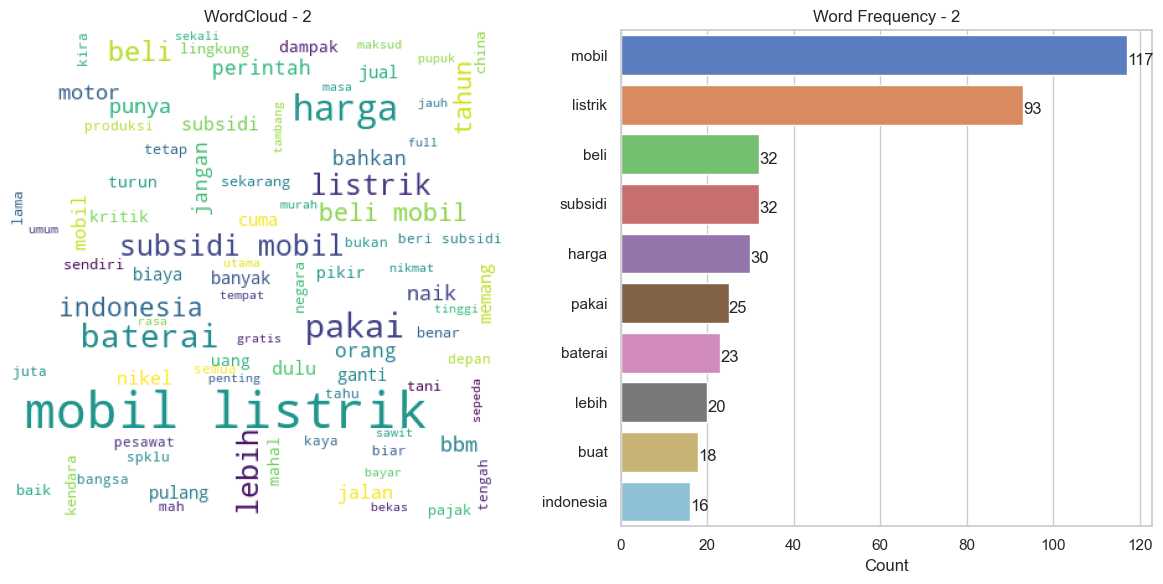

c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


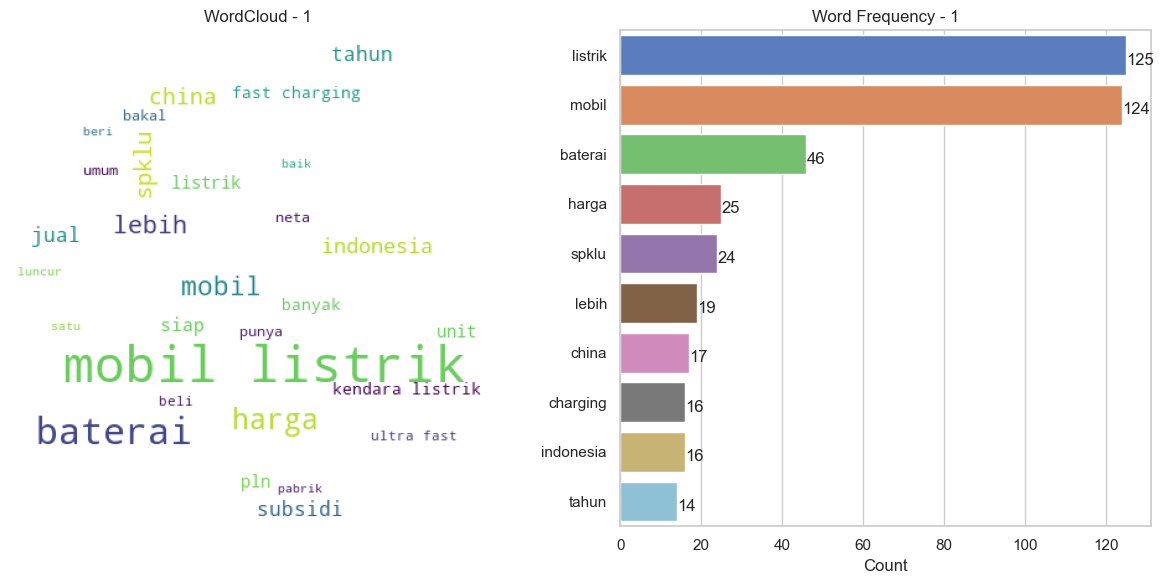

c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


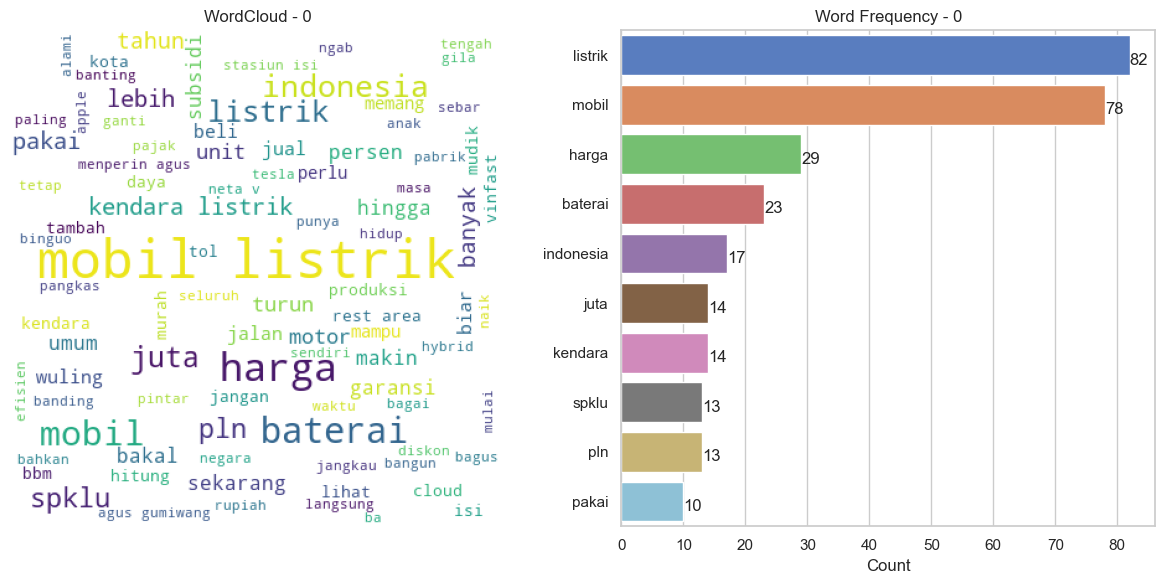

In [33]:
plot_wordcloud_and_frequency(df, 'stemmed_messages', 'Label', sw_id, 10)

## **3. Analisis Sentimen**
---

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation

kf = KFold(n_splits=5, random_state = 42, shuffle = True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
# Single Model
def train_model(model, data, targets):
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect', TfidfVectorizer()),
                         ('clf', model)])

    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

# Model Comparison
def train_model_comparison(models, X_train, y_train, X_val, y_val):
    results = []
    for name, model in models.items():
        text_clf = train_model(model, X_train, y_train)

        # Compute cross-validated scores
        cv_scores = cross_val_score(text_clf, X_train, y_train, cv = kf)
        train_acc = cv_scores.mean()

        # Predict on the validation data
        val_pred = text_clf.predict(X_val)

        # Compute accuracy on validation data
        val_acc = accuracy_score(y_val, val_pred)

        results.append([name, train_acc, val_acc])

    # Create DataFrame for results
    df_results = pd.DataFrame(results, columns=['Model', 'Train Accuracy', 'Val Accuracy'])
    df_results_sorted = df_results.sort_values(by='Val Accuracy', ascending=False)

    return df_results_sorted

In [36]:
# Splitting Data
X = df.copy()
y = X.pop("Label")

X_train, X_test, y_train, y_test = train_test_split(X.stemmed_messages, y, test_size = 0.2, random_state = 0, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0, stratify = y_train)

display(X_train.shape, X_test.shape, X_val.shape)

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

(245,)

(77,)

(62,)

In [37]:
# Model Candidate
models = {
    'Random Forest': RandomForestClassifier(random_state = 42),
    'Logistic Regression': LogisticRegression(random_state = 42),
    'Decision Tree': DecisionTreeClassifier(random_state = 42),
    'SVM': SVC(random_state = 42),
    'Naive Bayes': MultinomialNB(),
    'XGBoost': XGBClassifier(random_state = 42),
    'MLP': MLPClassifier(random_state=42)
}

results = train_model_comparison(models, X_train, y_train, X_val, y_val)
print(results)

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

                 Model  Train Accuracy  Val Accuracy
1  Logistic Regression        0.522449      0.612903
4          Naive Bayes        0.538776      0.612903
3                  SVM        0.510204      0.564516
6                  MLP        0.514286      0.483871
0        Random Forest        0.485714      0.467742
5              XGBoost        0.473469      0.435484
2        Decision Tree        0.440816      0.403226


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\an

In [38]:
# Membuat pipeline dengan TfidfVectorizer dan model SVM
svm_model = Pipeline([('vect', TfidfVectorizer()), ('clf', SVC(probability = True, random_state = 42))])

# Daftar hyperparameter yang ingin dituning
param_grid = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'clf__C': (1, 10, 100),
    'clf__kernel': ('linear', 'rbf'),
}

# Inisialisasi GridSearchCV dengan model, parameter grid, dan metrik evaluasi yang diinginkan
svm_grid = GridSearchCV(svm_model, param_grid, cv = kf, n_jobs = -1, verbose = 1, scoring = 'accuracy')

# Melatih GridSearchCV pada data train
svm_grid.fit(X_train, y_train)

# Menampilkan parameter terbaik
print("Best parameters found: ", svm_grid.best_params_)

# Akurasi data train dan validasi
print("Train Accuracy: ", svm_grid.best_score_)

svm_best = svm_grid.best_estimator_
y_pred = svm_best.predict(X_val)
print("Val Accuracy: ", accuracy_score(y_val, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'clf__C': 1, 'clf__kernel': 'rbf', 'vect__max_df': 0.75, 'vect__ngram_range': (1, 1)}
Train Accuracy:  0.5102040816326532
Val Accuracy:  0.5645161290322581


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

In [39]:
# Membuat pipeline dengan TfidfVectorizer dan model Random Forest
rf_model = Pipeline([('vect', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state=42))])

# Daftar hyperparameter yang ingin dituning
param_grid = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
}

# Inisialisasi GridSearchCV dengan model, parameter grid, dan metrik evaluasi yang diinginkan
rf_grid = GridSearchCV(rf_model, param_grid, cv=kf, n_jobs=-1, verbose=1, scoring='accuracy')

# Melatih GridSearchCV pada data train
rf_grid.fit(X_train, y_train)

# Menampilkan parameter terbaik
print("Best parameters found: ", rf_grid.best_params_)

# Akurasi data train dan validasi
print("Train Accuracy: ", rf_grid.best_score_)

# Evaluasi model terbaik pada data validasi
rf_best = rf_grid.best_estimator_
y_pred = rf_best.predict(X_val)
print("Val Accuracy: ", accuracy_score(y_val, y_pred))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Best parameters found:  {'clf__max_depth': 20, 'clf__n_estimators': 100, 'vect__max_df': 0.5, 'vect__ngram_range': (1, 1)}
Train Accuracy:  0.5306122448979591
Val Accuracy:  0.46774193548387094


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

In [40]:
# Membuat pipeline dengan TfidfVectorizer dan model Logistic Regression
lr_model = Pipeline([('vect', TfidfVectorizer()), ('clf', LogisticRegression(random_state=42))])

# Daftar hyperparameter yang ingin dituning
param_grid = {
    'vect__max_df': (0.5, 0.75, 1.0, 0.9),
    'vect__ngram_range': ((1, 1), (1, 3)),
    'clf__C': (1, 1.25, 1.5),
    'clf__penalty': ('l1', 'l2', 'elasticnet', 'none')
}

# Inisialisasi GridSearchCV dengan model, parameter grid, dan metrik evaluasi yang diinginkan
lr_grid = GridSearchCV(lr_model, param_grid, cv=kf, n_jobs=-1, verbose=1, scoring='accuracy')

# Melatih GridSearchCV pada data train
lr_grid.fit(X_train, y_train)

# Menampilkan parameter terbaik
print("Best parameters found: ", lr_grid.best_params_)

# Akurasi data train dan validasi
print("Train Accuracy: ", lr_grid.best_score_)
lr_best = lr_grid.best_estimator_
y_pred = lr_best.predict(X_val)
print("Val Accuracy: ", accuracy_score(y_val, y_pred))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found:  {'clf__C': 1.25, 'clf__penalty': 'l2', 'vect__max_df': 0.75, 'vect__ngram_range': (1, 1)}
Train Accuracy:  0.5346938775510204
Val Accuracy:  0.6129032258064516


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, s

In [41]:
# Melakukan prediksi pada data test menggunakan model terbaik yaitu SVM
y_pred = lr_best.predict(X_test)

# Membuat laporan klasifikasi
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.80      0.24      0.36        17
           1       0.57      0.82      0.68        33
           2       0.56      0.52      0.54        27

    accuracy                           0.58        77
   macro avg       0.64      0.52      0.53        77
weighted avg       0.62      0.58      0.56        77



c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

In [42]:
# Save prediction to df['pred']
df['pred'] = lr_best.predict(df['stemmed_messages'])

## **4. Visualisasi**
---

### **4.1. Visualisasi Sampel Prediksi**

In [43]:
def explain_prediction(X, y, model, idx):
    eLR1 = LimeTextExplainer(class_names=model.classes_)
    print("Actual Text : ", X.iloc[idx])
    print("Prediction : ", model.predict(X)[idx])
    print("Actual :     ", y.iloc[idx])

    prediction = model.predict(X)[idx]
    actual = y.iloc[idx]

    if prediction == actual:
        print("Prediction is correct.")
    else:
        print("Prediction is incorrect. Actual label:", actual)

    exp1 = eLR1.explain_instance(X.iloc[idx], model.predict_proba, top_labels=5)
    exp1.show_in_notebook()

# sampel data pertama pada data test
idx = 1
explain_prediction(X_test, y_test, svm_best, idx)

Actual Text :  usai luncur mobil listrik huawei ambisi buat stasiun isi baterai cepat
Prediction :  1
Actual :      1
Prediction is correct.


c:\Users\ASUS\anaconda3\Lib\site-packages\lime\explanation.py:194: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [44]:
# sampel data ke-55 pada data test (sesuaikan dengan jumlah data test)
idx = 58

explain_prediction(X_test, y_test, svm_best, idx)

Actual Text :  domo hybrid mobil listrik resmi luncur siap layan mobil hybrid listrik maintenance ganti baterai
Prediction :  1
Actual :      1
Prediction is correct.


c:\Users\ASUS\anaconda3\Lib\site-packages\lime\explanation.py:194: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### **4.2. Visualisasi *Word Cloud* Prediksi dengan Asli**

In [45]:
df_comp = df.copy()

# change label 0 to positive, 1 to neutral, and 2 to negative
df_comp['Label'] = df_comp['Label'].replace({0: 'positive', 1: 'neutral', 2: 'negative'})
df_comp['pred'] = df_comp['pred'].replace({0: 'positive', 1: 'neutral', 2: 'negative'})


c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


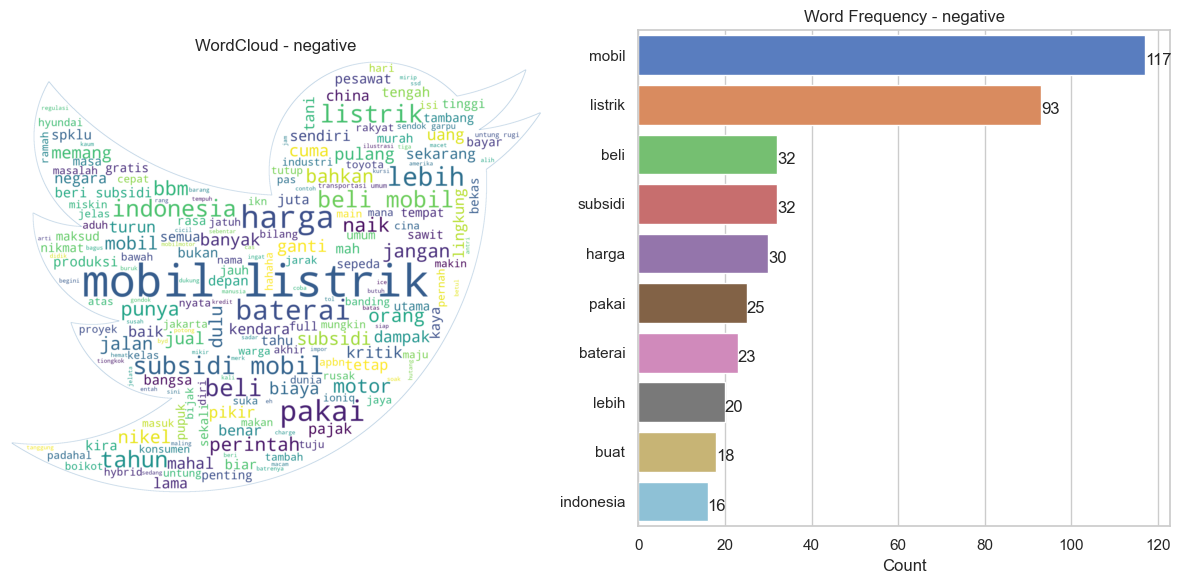

c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


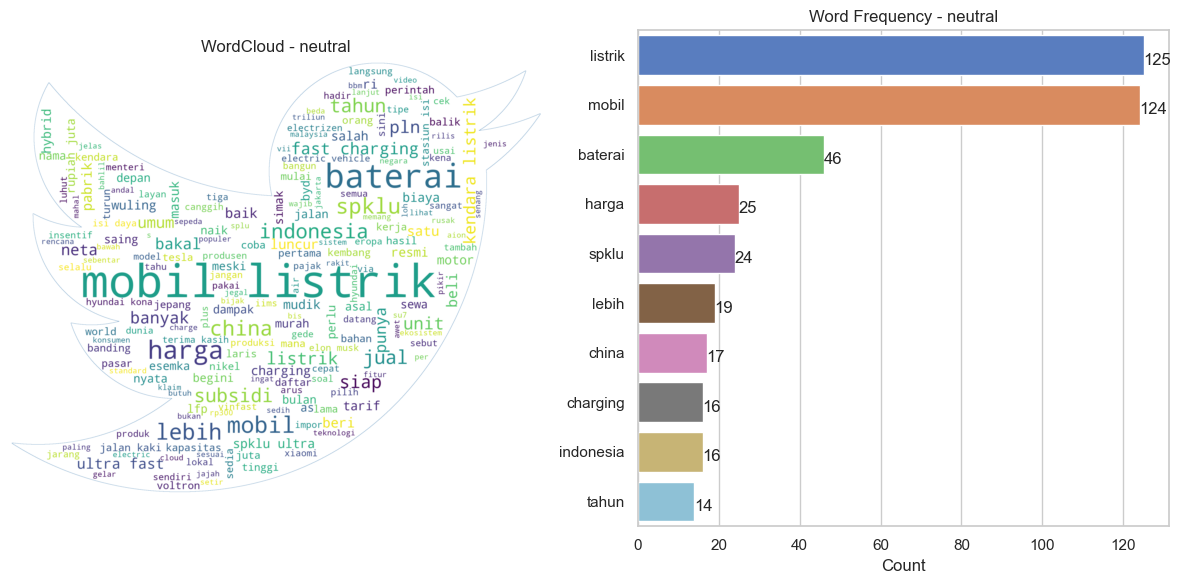

c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


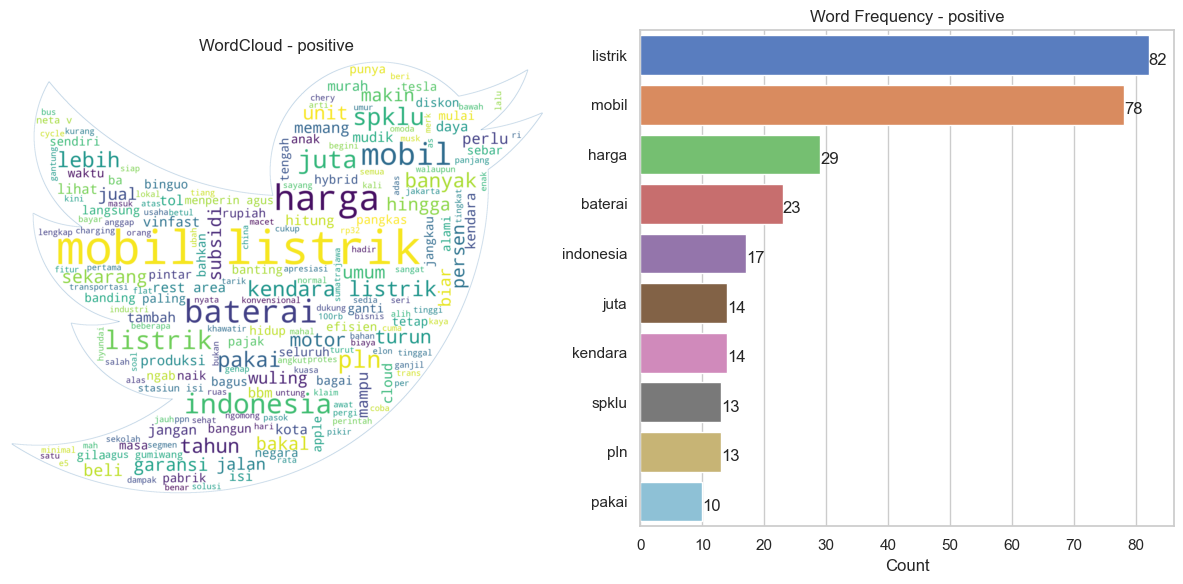

In [46]:
def plot_wordcloud_and_frequency_comparison(df, text_column, label_column, logo_path, stopwords, num_word=10):
    labels = df[label_column].unique()
    num_cols = 2

    # Load the logo image for the mask
    twitter_logo = Image.open(logo_path)
    mask = np.array(twitter_logo)
    mask[mask[:, :, -1] == 0] = 255  # Handle transparency if any
    mask = mask[:, :, :3]  # Use only the RGB channels

    for label in labels:
        fig, axes = plt.subplots(1, num_cols, figsize=(12, 6))

        # Filter text by label
        text = " ".join(df[df[label_column] == label][text_column].astype(str))

        # Generate wordcloud with a colormap and logo mask
        wordcloud = WordCloud(width=400, height=400,
                              background_color='white',
                              stopwords=stopwords,
                              min_font_size=10,
                              colormap='viridis',
                              mask=mask,  # Use the logo mask here
                              contour_color='steelblue',
                              contour_width=1).generate(text)

        # Display wordcloud
        axes[0].imshow(wordcloud, interpolation='bilinear')
        axes[0].axis("off")
        axes[0].set_title(f'WordCloud - {label}')

        # Compute word frequency
        text_data = df[df[label_column] == label][text_column]
        word_frequency = text_data.str.split(expand=True).stack().value_counts()
        freq = word_frequency.head(num_word)  # Adjust number of words

        # Display word frequency bar plot with a color palette
        sns.barplot(x=freq.values, y=freq.index, ax=axes[1], palette="muted")
        axes[1].set_title(f'Word Frequency - {label}')
        axes[1].set_xlabel('Count')
        for p in axes[1].patches:
            axes[1].annotate("{:.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + .5), ha='left', va='center')

        plt.tight_layout()
        plt.show()


plot_wordcloud_and_frequency_comparison(df_comp, 'stemmed_messages', 'Label', 'LogoTwitter.png', sw_id, 10)

c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


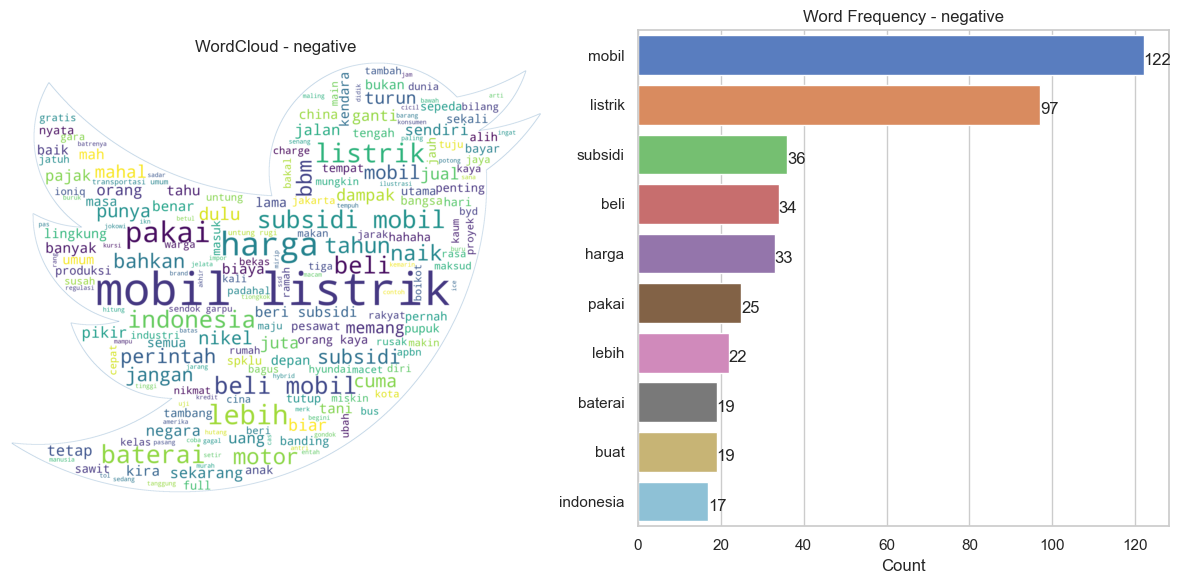

c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


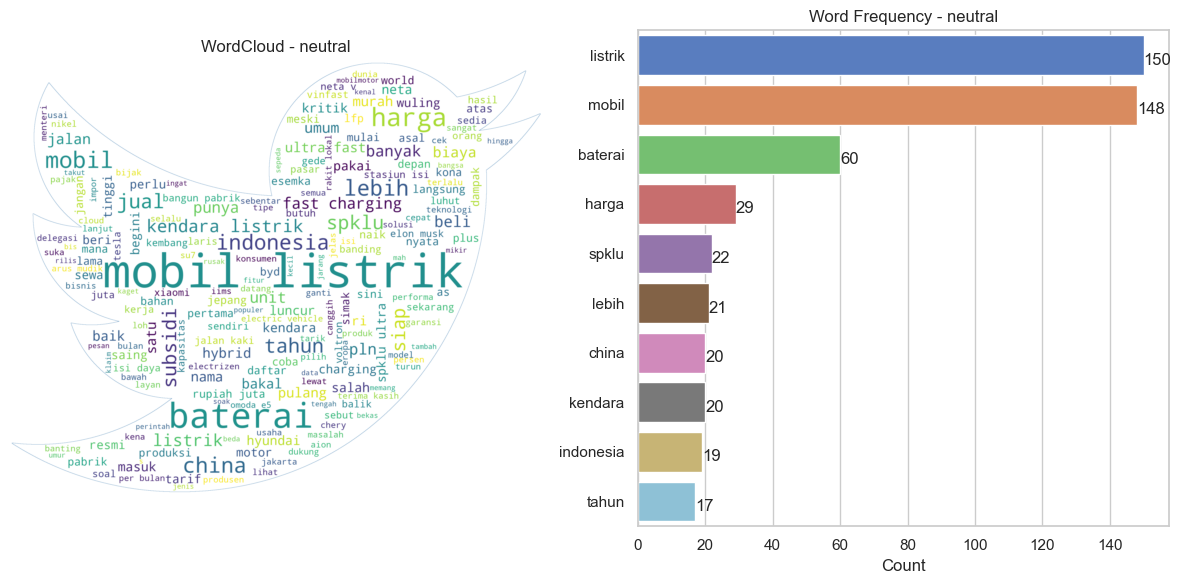

c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


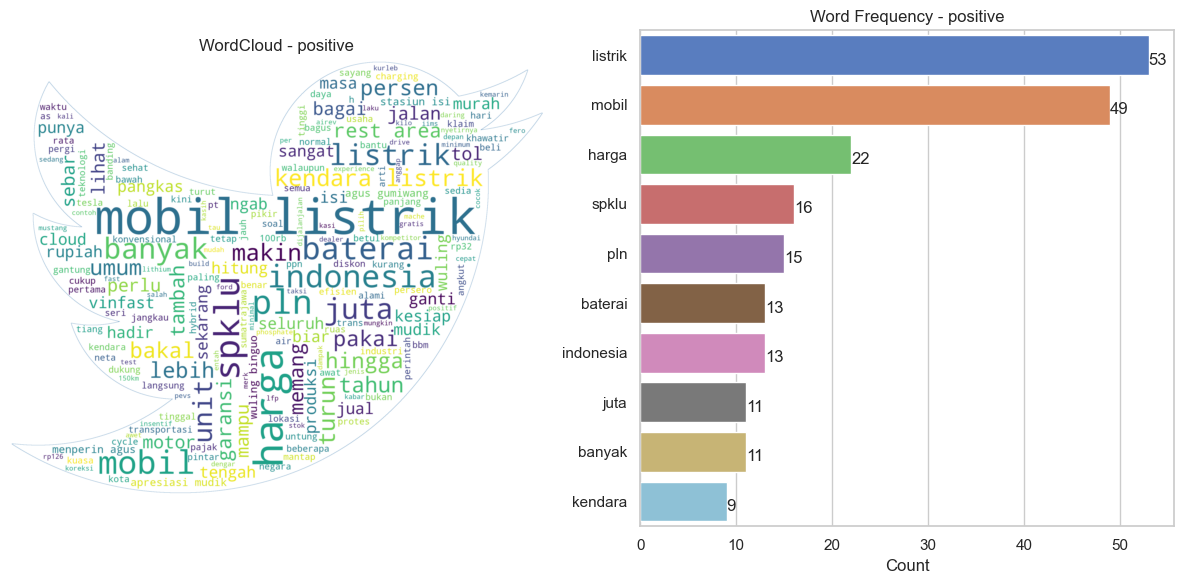

In [47]:
plot_wordcloud_and_frequency_comparison(df_comp, 'stemmed_messages', 'pred', 'LogoTwitter.png', sw_id, 10)

### **4.3. Proporsi Label Asli dengan Prediksi**

c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) inst

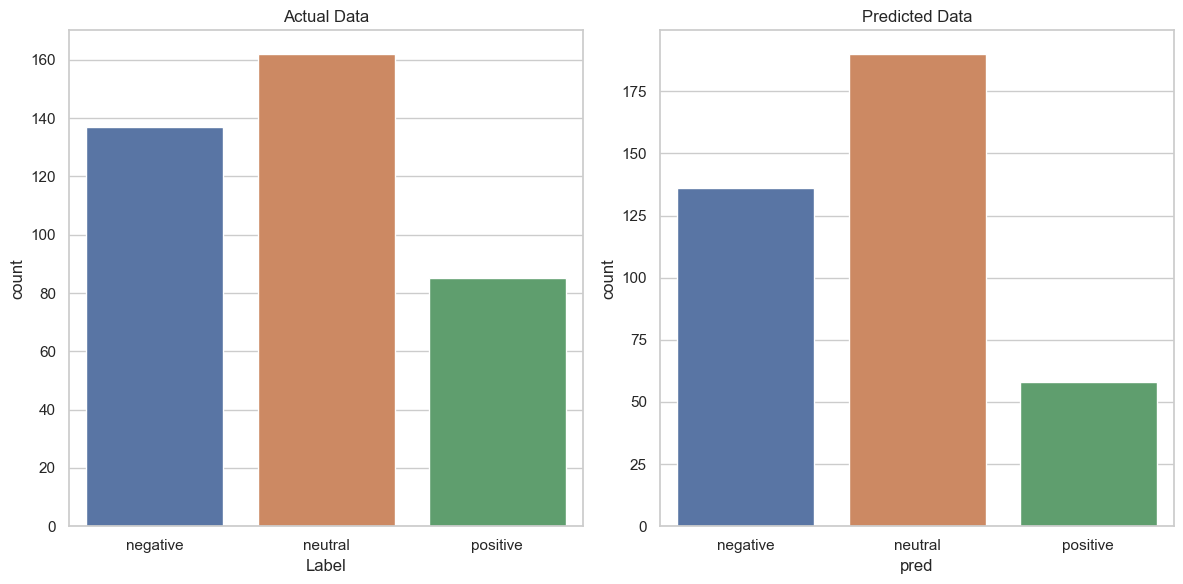

In [48]:
# Bar chart for actual data vs predicted data label

def plot_label_comparison(df, label_column, pred_column):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for actual data
    sns.countplot(x=label_column, data=df, ax=axes[0])
    axes[0].set_title('Actual Data')

    # Plot for predicted data
    sns.countplot(x=pred_column, data=df, ax=axes[1])
    axes[1].set_title('Predicted Data')

    plt.tight_layout()
    plt.show()

plot_label_comparison(df_comp, 'Label', 'pred')

## **5. Kesimpulan**
---

Analisis prediktif menunjukkan akurasi yang sedang, hanya sekitar 58%. Hal ini dikarenakan pemberian label pada dataset atau supervisi bersifat manual dan subjektif. Dengan kata lain, mesin belum dapat membedakan penilaian subjektif yang diberikan oleh manusia, seperti sarkasme. Pemberian label secara *unsupervised* atau *semi-supervised* tentu akan menaikkan akurasi pada model, tetapi penggunaannya tidak akan bermakna karena pada akhirnya mesin belajar dari dirinya sendiri--tidak ada proses campur tangan manusia. Dalam hal ini berarti mesin tidak dapat memotret kejadian yang secara nyata terjadi.

Analisis sentimen memperlihatkan bahwa masyarakat di Twitter cenderung tidak setuju terhadap adanya mobil listrik, khususnya di Indonesia. Alasan utama terkait penolakan atau persetujuan terlihat pada visualisasi *word cloud* dan hasilnya adalah sebagai berikut.
- Alasan penolakan yang terangkum adalah harganya yang mahal; subsidi mobil listrik yang diberikan pemerintah seharusnya tidak lebih penting daripada subsidi lainnya, seperti subsidi pendidikan; dan perawatan baterai yang tidak murah.
- Alasan penerimaan yang terangkum adalah harganya yang berpotensi turun; stasiun pengisian atau *charging* baterai yang mulai disediakan di berbagai tempat; dan untuk mengurangi kendaraan bertenaga BBM di Indonesia.

## **6. Validasi**
---

Input data validasi

In [49]:
dval = pd.read_csv('Validasi.csv')

In [50]:
display(dval)

username                                          tweet_url  \
0       AutonetMagz  https://x.com/AutonetMagz/status/1787783684604...   
1         kompascom  https://x.com/kompascom/status/178452976359779...   
2       heralddotID  https://x.com/heralddotID/status/1790729352478...   
3          VIVAcoid  https://x.com/VIVAcoid/status/1785856560327012395   
4       im_lawracle  https://x.com/im_lawracle/status/1750411509463...   
5          trio0303  https://x.com/trio0303/status/1789906340711645308   
6         darmaja09  https://x.com/darmaja09/status/178236164316870...   
7          detikcom  https://x.com/detikcom/status/1795001134811148454   
8           faz_hrp   https://x.com/faz_hrp/status/1788407158587236800   
9          detikcom  https://x.com/detikcom/status/1773712968485625884   
10  rohitsebastiian  https://x.com/rohitsebastiian/status/178912923...   
11      idntalk_com  https://x.com/idntalk_com/status/1786057128777...   
12      skyundocean  https://x.com/skyundocean/status/1788426157714...   
13        kompascom  https://x.com/kompascom/status/179425434060738...   
14      Golkar_News  https://x.com/Golkar_News/status/1774295159041...   
15          megonoo   https://x.com/megonoo/status/1789938969876054471   
16         pakar_ai  https://x.com/pakar_ai/status/1775831508395372912   
17      Spongetrons  https://x.com/Spongetrons/status/1752594044142...   
18       Agungbusby  https://x.com/Agungbusby/status/17902951384615...   
19          bb_cyma   https://x.com/bb_cyma/status/1787001681076715560   
20   DaniCicadasBdg  https://x.com/DaniCicadasBdg/status/1786470086...   
21    VitalongC1234  https://x.com/VitalongC1234/status/17884134389...   
22       antaranews  https://x.com/antaranews/status/17584879319820...   
23          tya1811   https://x.com/tya1811/status/1763116059727647204   
24         IrwindaF  https://x.com/IrwindaF/status/1788427511149580645   
25     CNNIndonesia  https://x.com/CNNIndonesia/status/175475087703...   
26      katadataoto  https://x.com/katadataoto/status/1774381900716...   
27  FaisalA64763335  https://x.com/FaisalA64763335/status/174848487...   
28          TopanTj   https://x.com/TopanTj/status/1790236890228195631   
29       tanyakanrl  https://x.com/tanyakanrl/status/17740489996009...   
30        diyasprdn  https://x.com/diyasprdn/status/178528629212700...   
31  NurrohmahL47510  https://x.com/NurrohmahL47510/status/178915436...   
32        SINDOnews  https://x.com/SINDOnews/status/179413330296373...   
33           suvcly    https://x.com/suvcly/status/1789026216999285234   
34      katadataoto  https://x.com/katadataoto/status/1785625789486...   
35   WulingMotorsID  https://x.com/WulingMotorsID/status/1787029465...   
36         detikcom  https://x.com/detikcom/status/1747243806125076859   
37           Rizxfa    https://x.com/Rizxfa/status/1787238775523082663   
38    cnbcindonesia  https://x.com/cnbcindonesia/status/17793994762...   
39        SINDOnews  https://x.com/SINDOnews/status/179497999487744...   
40        RidNgemil  https://x.com/RidNgemil/status/178533218734645...   
41        kompascom  https://x.com/kompascom/status/179596448465539...   
42      okezonenews  https://x.com/okezonenews/status/1784827593545...   
43         kumparan  https://x.com/kumparan/status/1790548799372583425   
44         kumparan  https://x.com/kumparan/status/1792737478430085349   
45         detikoto  https://x.com/detikoto/status/1795345220483293252   
46         detikcom  https://x.com/detikcom/status/1772901873722531990   
47      ikhwanuddin  https://x.com/ikhwanuddin/status/1774087942258...   
48         detikcom  https://x.com/detikcom/status/1752180334093832536   
49      idx_channel  https://x.com/idx_channel/status/1754711512512...   

                                            full_text    label  
0   SPKLU Voltron perluas jaringan lewat kerjasama...  positif  
1   Kompresor AC mobil listrik bekerja mengambil d...   netral  
2   PT PLN (Persero) melalui anak usahany

### **6.1. Validation Data Preprocessing**

Prapemrosesan menggunakan fungsi yang sama pada data latih yang digunakan untuk membuat model sebelumnya.

In [51]:
# Prepocessing for validation data
dval['full_text'] = dval['full_text'].apply(slang_preprocess)
dval['stop_word'] = dval['full_text'].apply(stop_word_preprocessing)
dval['stemmed_messages'] = dval['stop_word'].apply(stem_words)

In [55]:
# Recode label
dval['label'] = dval['label'].replace({'positif': 0, 'netral': 1, 'negatif': 2})

C:\Users\ASUS\AppData\Local\Temp\ipykernel_25708\2427511325.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dval['label'] = dval['label'].replace({'positif': 0, 'netral': 1, 'negatif': 2})


### **6.2. Modelling**

In [57]:
# Modelling on validation data using best model
y_val_pred = lr_best.predict(dval['stemmed_messages'])

# Classification report
classification_rep = classification_report(dval['label'], y_val_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.75      0.19      0.30        16
           1       0.47      0.84      0.60        19
           2       0.50      0.40      0.44        15

    accuracy                           0.50        50
   macro avg       0.57      0.48      0.45        50
weighted avg       0.57      0.50      0.46        50



c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

In [59]:
# Confusion matrix
cm = confusion_matrix(dval['label'], y_val_pred)
cm

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

array([[ 3, 10,  3],
       [ 0, 16,  3],
       [ 1,  8,  6]], dtype=int64)

In [60]:
# Full text pred
y_val_pred = lr_best.predict(dval['full_text'])

# Classification report
classification_rep = classification_report(dval['label'], y_val_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       1.00      0.12      0.22        16
           1       0.46      0.89      0.61        19
           2       0.64      0.47      0.54        15

    accuracy                           0.52        50
   macro avg       0.70      0.50      0.46        50
weighted avg       0.69      0.52      0.46        50



c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

Diperoleh $F_1$ *score* pada data validasi dengan menggunakan model terbaik (regresi logistik) adalah sebesar 0.45 untuk macro average stemmed text dan 0.46 untuk weighted average stemmed text.

In [82]:
# List Models on Validation Data
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Naive Bayes': MultinomialNB(),
    'XGBoost': XGBClassifier(random_state=42),
    'MLP': MLPClassifier(random_state=42)
}

results = train_model_comparison(models, X_train, y_train, dval['stemmed_messages'], dval['label'])
print(results)

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

                 Model  Train Accuracy  Val Accuracy
1  Logistic Regression        0.522449          0.52
0        Random Forest        0.485714          0.50
3                  SVM        0.510204          0.48
4          Naive Bayes        0.538776          0.48
5              XGBoost        0.473469          0.46
6                  MLP        0.514286          0.46
2        Decision Tree        0.440816          0.36


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ASUS\an

Terlihat bahwa regresi logistik memang memberikan performa terbaik.